In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import sys

In [7]:
from escape.parse import swissfel
from jungfrau_utils import apply_gain_pede, apply_geometry

sys.path.insert(0, '../src/')
from data_analysis import *
from masking import *

In [3]:
path = '/sf/bernina/data/p17743/res/scan_info/'
run = '0019_droplets_10um_2mm'
num_shots = 100
#process_run(run, path, num_shots=10, iq_threshold=0)

In [4]:
# load data
file_path = '%srun%s.json'%(path,run)
print('-- Loading data:%s'%file_path)
data = swissfel.parseScanEco_v01(file_path,createEscArrays=True,memlimit_mD_MB=50)
jf7 = data['JF07T32V01'] # large JungFrau data
jf3 = data['JF03T01V01'] # i0 monitor data 
total_shots = jf7.data.shape[jf7.eventDim]
if (num_shots>total_shots) or (num_shots==0):
    num_shots = total_shots

-- Loading data:/sf/bernina/data/p17743/res/scan_info/run0019_droplets_10um_2mm.json
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH6:2 in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH7:2 in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH4:2 in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH5:2 in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH6:2 in cycle 1
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH4:2 in cycle 1
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH7:2 in cycle 1
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH5:2 in cycle 1
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH6:2 in cycle 2
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH4:2 in cycle 2
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH7:2 in cycle 2
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH5:2 in cycle 2
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH6:2 in cycle 3
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH4:2 in cycle 3
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH

In [5]:
# load corrections
gains,pede,noise,mask = load_corrections(run)
gains_i0,pede_i0,noise_i0,mask_i0 = load_corrections_i0(run)
old_mask = np.array(mask)

using pedestals from: %s /sf/bernina/data/p17743/res/JF_pedestal/pedestal_20190130_1925.JF07T32V01.res.h5


<IPython.core.display.Javascript object>


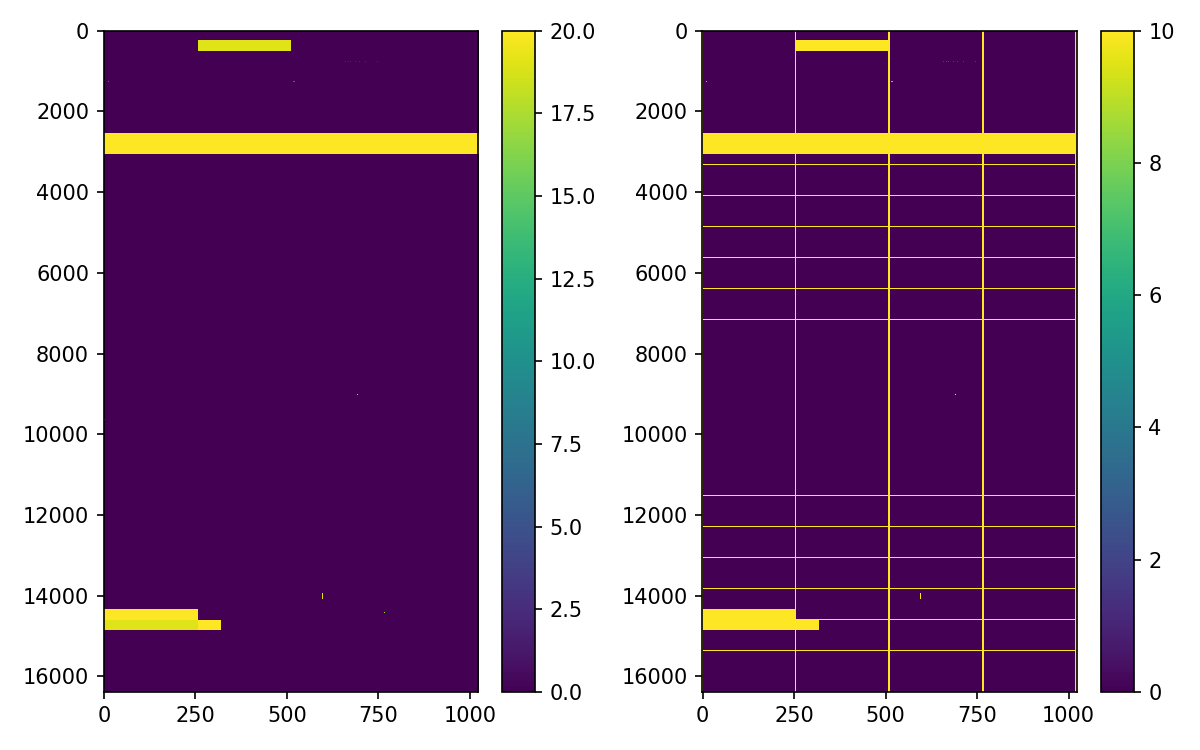

In [8]:
dp_mask = mask_double_pixels(mask)

plt.figure(figsize = [8,5])
plt.subplot(1,2,1)
plt.imshow(old_mask,aspect='auto',clim=[0,20])
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(dp_mask,aspect='auto',clim=[0,10])
plt.colorbar()
plt.tight_layout()
plt.show()

In [9]:
mask_geom = ~apply_geometry(~(mask>0),'JF07T32V01')
mask_inv = np.logical_not(mask_geom) #inverted: 0 masked, 1 not masked

mask_geom2 = ~apply_geometry(~(dp_mask>0),'JF07T32V01')
mask_inv2 = np.logical_not(mask_geom2) #inverted: 0 masked, 1 not masked


In [10]:
h5path = '/sf/bernina/data/p17743/res/work/hdf5/run%s.h5'%run
h5file = h5py.File(h5path,'r')
img = h5file['JF7/2D_sum'][:]
r  = h5file['JF7/Q_bins'][:]
Iq = h5file['JF7/I_Q'][:]
#i0 = h5file['JF3/i0'].value 
nshots = h5file['JF7/num_shots'].value
q = q_scale(r, detector_distance=0.12)
print(nshots)
img/=nshots

18000


<IPython.core.display.Javascript object>


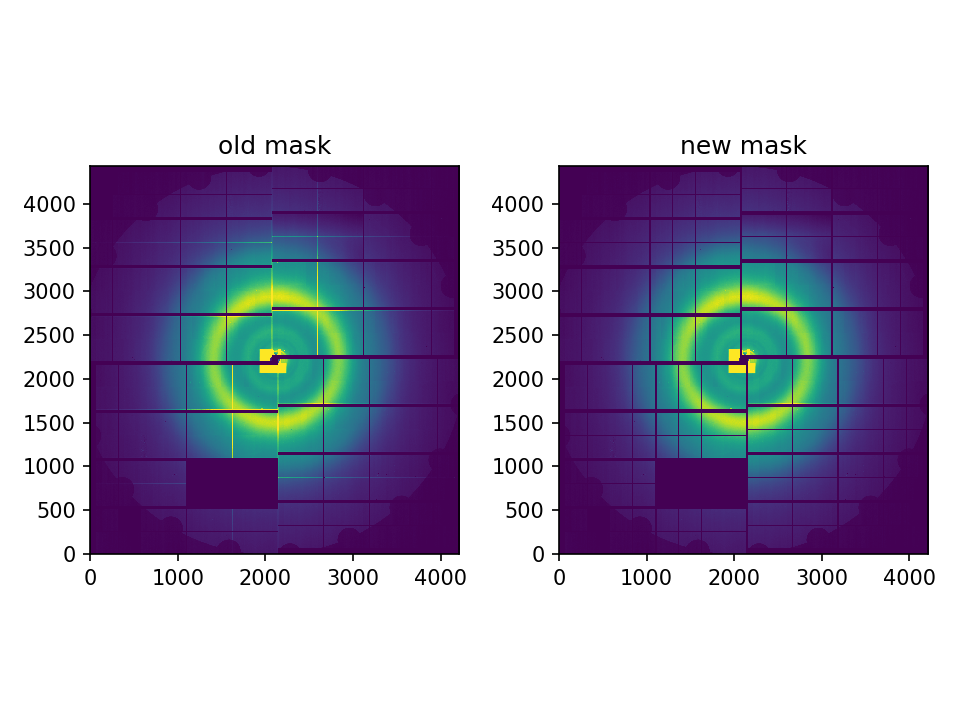

In [11]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(img,clim=[0,20],origin='lower')
plt.title('old mask')

plt.subplot(1,2,2)
plt.imshow(img*mask_inv2,clim=[0,20],origin='lower')
plt.title('new mask')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


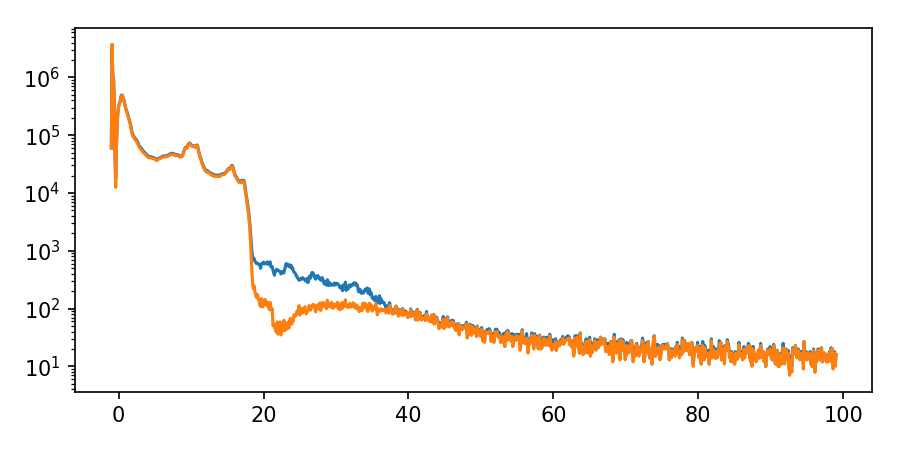

In [12]:
plt.figure(figsize=[6,3])
bi,bf,db = 0,100,.1
bins = np.arange(bi-db,bf+db,db)
hy,hx = np.histogram(img,bins=bins)
plt.plot(hx[1:]-1,hy)

bins = np.arange(bi-db,bf+db,db)
hy,hx = np.histogram(img*mask_inv2,bins=bins)
plt.plot(hx[1:]-1,hy)
plt.yscale('log',nonposy='clip')
plt.tight_layout()
#plt.xlim(-1,5)
plt.show()